In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **LIBRARIES**

In [ ]:
import tensorflow as tf
import numpy as np
from numpy import asarray
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import datetime
import pathlib

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.17.1


In [ ]:
seed = 42127
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [ ]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# **DATASET**




In [ ]:
def genAugmLayer(seed):
    return tf.keras.Sequential([
     tfkl.RandomFlip("horizontal"),
     tfkl.RandomRotation(0.5),
     tfkl.RandomZoom( height_factor=(-0.3, 0.3), width_factor=(-0.3, 0.3),fill_mode = 'reflect',seed=seed),
     tfkl.RandomTranslation( height_factor=(-0.3, 0.3),width_factor=(-0.3, 0.3),seed=13)])

In [ ]:
imbalClasses = tf.keras.utils.image_dataset_from_directory(
    '../input/dataset-1and6/only1and6',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(96,96),
    subset = 'training',
    validation_split=0.2,
    seed=seed,
)

data_augmentation1 = genAugmLayer(17)
dataAugmImbal = imbalClasses.map(lambda x , y : (data_augmentation1(x), y))
data_augmentation2 = genAugmLayer(271)
dataAugmImbal = dataAugmImbal.concatenate(imbalClasses.map(lambda x , y : (data_augmentation2(x), y))) #double samples of classes 1 and 6

Found 414 files belonging to 8 classes.
Using 332 files for training.


In [ ]:
from tensorflow.keras.utils import to_categorical
dataset_path_train = "/content/drive/MyDrive/Homework1/dataset/npz_NoTestSet/filtered_classes_noOutliears/train_set_StrongAugmentation_Balanced_WithSoftCutMix/train_set_Unified.npz"
dataset_path_val = '/content/drive/MyDrive/Homework1/dataset/npz_NoTestSet/filtered_classes_noOutliears/val_set.npz'

data = np.load(dataset_path_train)
X_train = data['images']
y_train = data['labels'].flatten()
y_train = to_categorical(y_train, num_classes=8)

data = np.load(dataset_path_val)
X_val = data['images']
y_val = data['labels'].flatten()
y_val = to_categorical(y_val, num_classes=8)

In [ ]:
import numpy as np

def images_per_class(X_train, y_train):
  """Counts the number of images per class in X_train.

  Args:
    X_train: The training data.
    y_train: The training labels (one-hot encoded).

  Returns:
    A dictionary mapping class labels to the number of images in that class.
  """
  class_counts = {}
  unique_labels = np.argmax(y_train, axis=1) #get numerical labels from one-hot

  for label in np.unique(unique_labels):
    class_counts[label] = np.sum(unique_labels == label)
  return class_counts

# Example usage:
class_counts = images_per_class(X_train, y_train)
print(class_counts)

{0: 2039, 1: 2039, 2: 2039, 3: 2039, 4: 2039, 5: 2039, 6: 2039, 7: 2039}


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
training_set = training_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

# **Transfer Learning**

In [ ]:
initial_time = datetime.datetime.now()
input_shape = (96, 96, 3)
epochs = 50

**We import VGG19 without top, and we preprocess our data with the preprocess function of VGG**

In [ ]:
supernet = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(128,128,3))
supernet.trainable = False
#training_set = training_set.map(lambda x,y: (tf.keras.applications.vgg19.preprocess_input(x), y))
#validation_set = validation_set.map(lambda x,y: (tf.keras.applications.vgg19.preprocess_input(x),y))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
#ARCHITECTURE
input_layer = tfkl.Input(input_shape)

x = tfkl.Resizing(height = 128, width = 128, interpolation = 'bilinear' )(input_layer)

x = supernet(x)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dropout(rate=0.3)(x)
x = tfkl.Dense(units=128, name='Dense3', kernel_initializer=tfk.initializers.HeUniform(seed),  activation='relu')(x)
x = tfkl.Dropout(rate=0.3)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(x)

model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

#model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

In [ ]:
from datetime import datetime
def create_folders_and_callbacks(model_name):

    callbacks = []

    # Early Stopping
    # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
    callbacks.append(es_callback)
    return callbacks

In [ ]:
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense3 (Dense)                       │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,091,080 (76.64 MB)

 Trainable params: 66,696 (260.53 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

**We have all the layers of VGG19 non trainable, because we want to do Transfer Learning**

In [ ]:
for i, layer in enumerate(model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)

0 input_layer False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 False
18 block5_conv2 False
19 block5_conv3 False
20 block5_conv4 False
21 block5_pool False


### Keras Tuner

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


## Apply Keras Tuning during training

In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import layers

def create_model(hp):

    input_layer = tfk.Input(shape=(96, 96, 3))  # Adjust shape as needed
    x = tfkl.Resizing(height=128, width=128, interpolation='bilinear')(input_layer)

    # Assuming `supernet` is defined or imported
    x = supernet(x)
    x = tfkl.GlobalAveragePooling2D()(x)
    x = tfkl.Dropout(rate=hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.1))(x) # Use hp to define dropout rate
    x = tfkl.Dense(units=hp.Int('dense_units', min_value=128, max_value=256, step=32), name='Dense3', kernel_initializer=tfk.initializers.HeUniform(seed), activation=hp.Choice('activation', values=['relu', 'tanh']))(x) #Use hp to define dense units and activation
    x = tfkl.Dropout(rate=hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.1))(x) # Use hp to define dropout rate
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(x)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model

    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),loss='categorical_crossentropy',metrics=['accuracy']) # Use hp to define optimizer
    return model

# Instantiate the tuner (Hyperband in this case)
tuner = kt.Hyperband(
    create_model,               # The model-building function
    objective='val_accuracy',  # The objective metric to optimize
    max_epochs=5,             # Max number of epochs for each trial
    factor=3,                  # Factor by which to increase the number of resources for each trial
    directory='kt_dir',        # Directory to store the search results
    project_name='tune_model'  # Name for the project in the directory
)

# Print the search space
tuner.search_space_summary()
# Assuming X_train, y_train, X_val, y_val are already defined
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Trial 10 Complete [00h 03m 56s]
val_accuracy: 0.6043814420700073

Best val_accuracy So Far: 0.6473367810249329
Total elapsed time: 00h 23m 43s


In [ ]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
output_dir = '/content/drive/My Drive/Homework1/net_output'  # Directory to save logs, plots, and models


# Save the trained model with the final accuracy in the filename
model_filename = f'{output_dir}/VGG19_SoftCutMixUP_GridSearch.keras'

# Save the best model to a .keras file
best_model.save(model_filename)
print(f"Best model saved at {model_filename}")

Best model saved at /content/drive/My Drive/Homework1/net_output/VGG19_SoftCutMixUP_GridSearch.keras


In [ ]:
callbacks = create_folders_and_callbacks(model_name='myModel')

history = model.fit(
    x=X_train,
    y=y_train,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

Epoch 1/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 54s 74ms/step - accuracy: 0.1516 - loss: 8.6623 - val_accuracy: 0.3351 - val_loss: 1.8604
Epoch 2/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 60s 53ms/step - accuracy: 0.2544 - loss: 2.9441 - val_accuracy: 0.3037 - val_loss: 1.7357
Epoch 3/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 43s 57ms/step - accuracy: 0.2698 - loss: 2.0952 - val_accuracy: 0.3200 - val_loss: 1.7065
Epoch 4/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - accuracy: 0.2953 - loss: 1.8728 - val_accuracy: 0.3647 - val_loss: 1.6306
Epoch 5/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.3263 - loss: 1.7726 - val_accuracy: 0.4016 - val_loss: 1.5495
Epoch 6/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 43s 57ms/step - accuracy: 0.3529 - loss: 1.6732 - val_accuracy: 0.4343 - val_loss: 1.4444
Epoch 7/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.3831 - loss: 1.5951 - val_accuracy: 0.4661 - val_loss: 1.3772
Epoch 8/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 43s 59ms/step - accuracy: 0.4077 - loss: 1.5412 - 

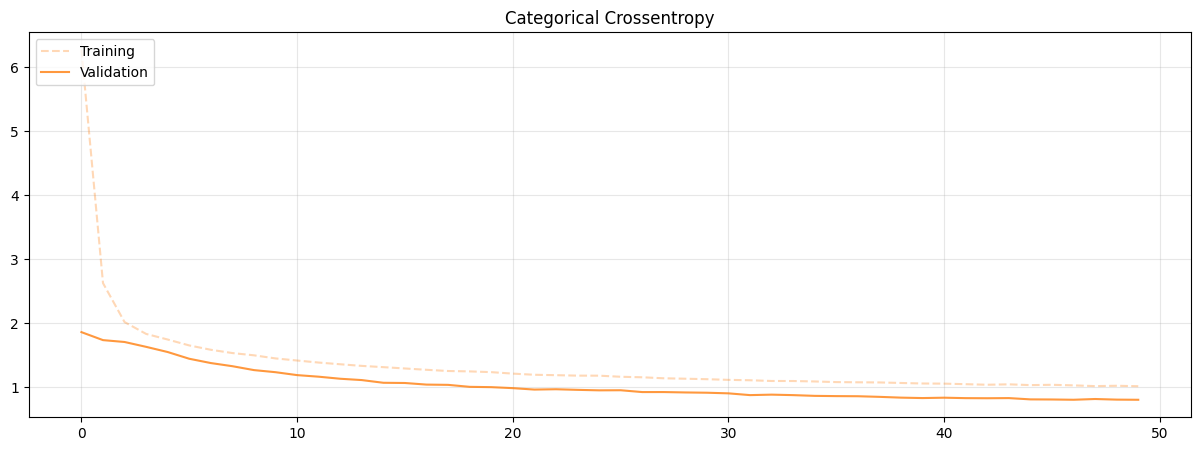

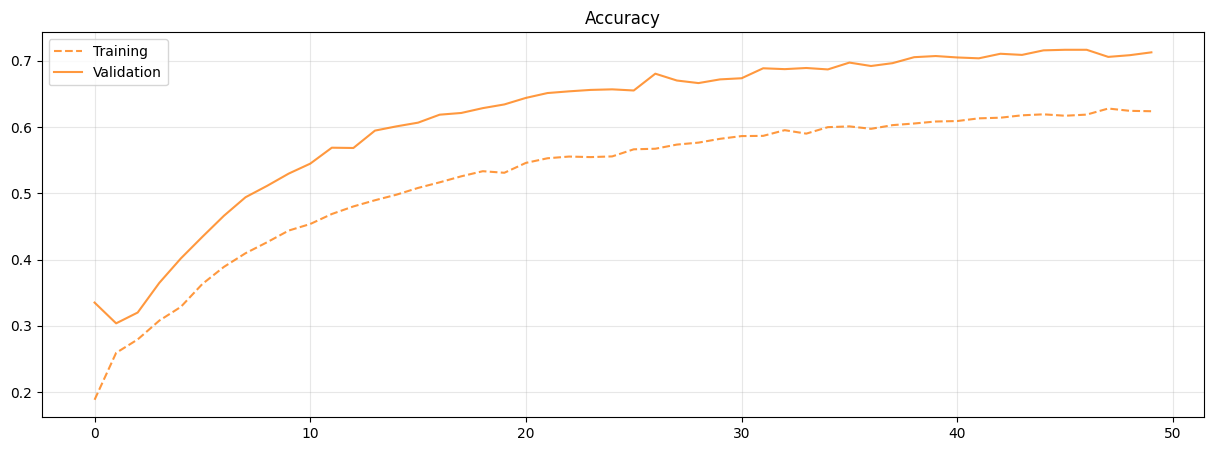

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:

output_dir = '/content/drive/My Drive/Homework1/net_output'  # Directory to save logs, plots, and models


# Save the trained model with the final accuracy in the filename
model_filename = f'{output_dir}/VGG19_SoftCutMixUP.keras'
model.save(model_filename)
print(f"Model saved at {model_filename}")

Model saved at /content/drive/My Drive/Homework1/net_output/VGG19_SoftCutMixUP.keras


# Fine Tuning

In [ ]:
# prompt: import model from model_file name

from tensorflow import keras

# Assuming your model is saved as 'VGG19_SoftCutMixUP.keras' in the specified directory
model_path = '/content/drive/My Drive/Homework1/net_output/VGG19_SoftCutMixUP.keras'

# Load the model
model = keras.models.load_model(model_path)

# Now you can use the loaded model
# Example: Make a prediction
# predictions = model.predict(new_data)

In [ ]:
supernet = model.get_layer("vgg19")

In [ ]:
supernet.trainable = True

# Freeze all layers except the last 14
for layer in supernet.layers[:-14]:
    layer.trainable = False

# Unfreeze the last 14 layers
for layer in supernet.layers[-14:]:
    layer.trainable = True

**Now we want to do fine tuning, so we set the last layers of VGG to trainable**

In [ ]:
supernet.trainable = True

for i, layer in enumerate(model.get_layer('vgg19').layers[:-1]):
       layer.trainable=False

for i, layer in enumerate(model.get_layer('vgg19').layers[-14:-1]):
    layer.trainable = True

In [ ]:
for i, layer in enumerate(model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)

0 input_layer False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [ ]:
# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense3 (Dense)                       │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,091,080 (76.64 MB)

 Trainable params: 19,535,752 (74.52 MB)

 Non-trainable params: 555,328 (2.12 MB)

In [ ]:
callbacks = create_folders_and_callbacks(model_name='myModel')

history = model.fit(
    x=X_train,
    y=y_train,
    epochs = 10,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

Epoch 1/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 125s 182ms/step - accuracy: 0.5721 - loss: 1.2476 - val_accuracy: 0.7904 - val_loss: 1.4199
Epoch 2/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 109s 152ms/step - accuracy: 0.8911 - loss: 0.3647 - val_accuracy: 0.7990 - val_loss: 1.1900
Epoch 3/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 140s 149ms/step - accuracy: 0.9349 - loss: 0.2178 - val_accuracy: 0.9394 - val_loss: 0.2704
Epoch 4/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 142s 149ms/step - accuracy: 0.9525 - loss: 0.1662 - val_accuracy: 0.9132 - val_loss: 0.4755
Epoch 5/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 142s 149ms/step - accuracy: 0.9628 - loss: 0.1324 - val_accuracy: 0.9536 - val_loss: 0.1812
Epoch 6/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 86s 148ms/step - accuracy: 0.9630 - loss: 0.1258 - val_accuracy: 0.9695 - val_loss: 0.1450
Epoch 7/10


In [ ]:

output_dir = '/content/drive/My Drive/Homework1/net_output'  # Directory to save logs, plots, and models


# Save the trained model with the final accuracy in the filename
model_filename = f'{output_dir}/VGG19_SoftCutMix_FineTuning10Epoche.keras'
model.save(model_filename)
print(f"Model saved at {model_filename}")

Model saved at /content/drive/My Drive/Homework1/net_output/VGG19_SoftCutMix_FineTuning.keras


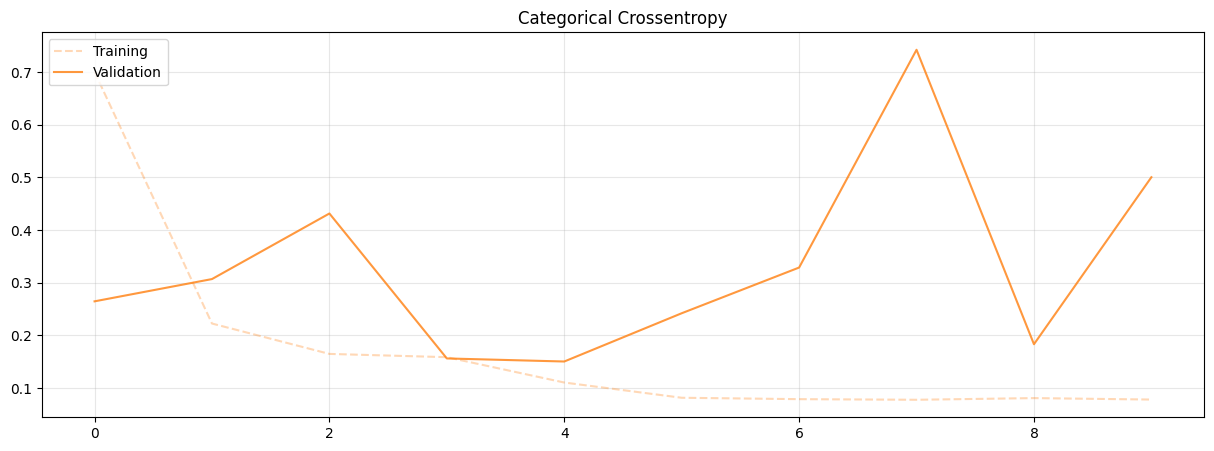

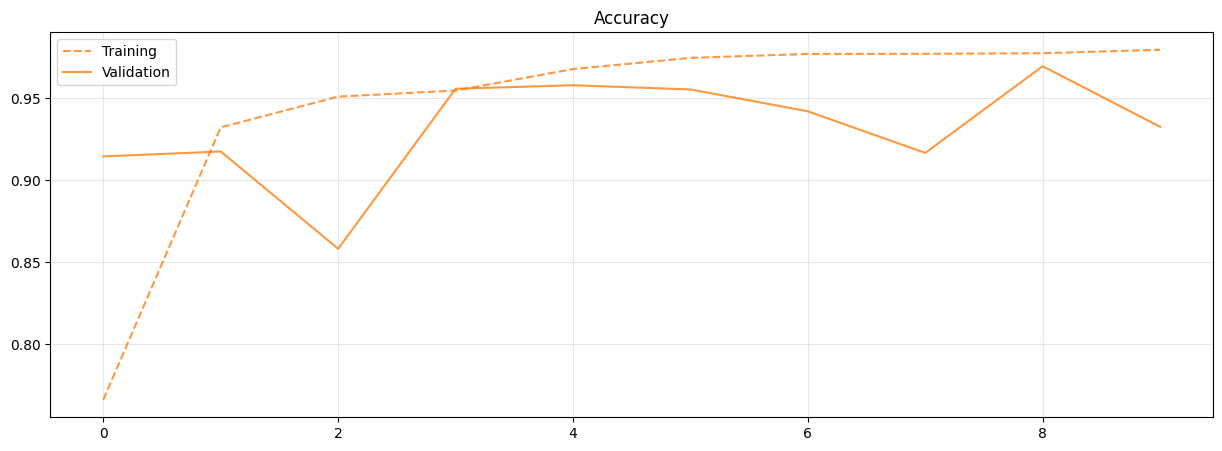

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()